# Physical attacks - Detection

## I - Modules

In [3]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import os



## II - Charger donnée

Utilisons donnée préparée :

In [8]:
df_normal = pd.read_csv("preparation/physical_normal.csv")
df_attack_1 = pd.read_csv("preparation/physical_1.csv")
df_attack_2 = pd.read_csv("preparation/physical_2.csv")
df_attack_3 = pd.read_csv("preparation/physical_3.csv")
df_attack_4 = pd.read_csv("preparation/physical_4.csv")

In [9]:
df_normal.head()

,Unnamed: 0,Tank_1,Tank_2,Tank_3,Tank_4,Tank_5,Tank_6,Tank_7,Tank_8,Pump_1,...,Valv_14,Valv_15,Valv_16,Valv_17,Valv_18,Valv_19,Valv_20,Valv_21,Valv_22,Label
0,0,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
1,1,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
2,2,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
3,3,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
4,4,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal


In [10]:
df_attack_1.head()

,Unnamed: 0,Tank_1,Tank_2,Tank_3,Tank_4,Tank_5,Tank_6,Tank_7,Tank_8,Pump_1,...,Valv_14,Valv_15,Valv_16,Valv_17,Valv_18,Valv_19,Valv_20,Valv_21,Valv_22,Label
0,0,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
1,1,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
2,2,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
3,3,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
4,4,0,0,0,0,0,0,0,0,True,...,False,False,False,False,False,False,False,False,False,normal


## III - Fonctions

### 0 - Fonction d'évaluation et matrice de confusion

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels, save_cof_mat=False, conf_mat_name="conf_mat", model_name="model"):
    cm = confusion_matrix(y_true, y_preds,normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))

    labels_for_fig = [(l[0:4]+'.' if isinstance(l, str) else str(l)) for l in labels]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels_for_fig)
    disp.plot(cmap="Blues", values_format="4f", ax=ax, colorbar=False)
    
    try:
        disp.plot(cmap="Blues", values_format="4f", ax=ax, colorbar=False)
        folder_path= f"./images/physical/Results/{model_name}/Confusion_matrix/"
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        if save_cof_mat:
            plt.savefig(f"./images/physical/Results/{model_name}/Confusion_matrix/{conf_mat_name}.png")
    except:
        print("ERREUR MATRICE DE CONFUSION")
        print(pd.unique(y_preds))
        print(pd.unique(y_true))
        print(labels)
        
    plt.title("Normalized confusion matrix")
    plt.show()



def eval_model(y_pred, y_test, labels, save_cof_mat=False, conf_mat_name="conf_mat", model_name="model"):
    plot_confusion_matrix(list(y_pred), list(y_test), labels, save_cof_mat, conf_mat_name, model_name)

    print(classification_report(y_test, y_pred))
    
    # Print the confusion matrix directly
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    # Compute and print metrics for each class
    for i, label in enumerate(labels):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        # print("tp", tp)
        # print("fp", fp)
        # print("fn", fn)
        # print("tn", tn)
        
        tnr = tn / (tn + fp)  # True negative rate
        tpr = tp / (tp + fn)  # True positive rate
        fnr = fn / (fn + tp)  # False negative rate
        fpr = fp / (fp + tn)  # False positive rate

        
        
        print(f"\nMetrics for class {label}:")
        print(f"True negative rate: {tnr:.4f}")
        print(f"True positive rate: {tpr:.4f}")
        print(f"False negative rate: {fnr:.4f}")
        print(f"False positive rate: {fpr:.4f}")
    
    
    

### 2 - KNN

In [12]:
def KNN_attack_detection(df, name_df="xxx", model_name="xxx"):
    new_df = df.copy()
    print("taille",len(df))
    X = new_df.drop('Label', axis=1)  # Caractéristiques
    y = new_df['Label']  # Cible
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # k autour de 10 (à tester)
    k = len(pd.unique(y_test))

    
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)


    y_pred = knn_model.predict(X_test)
    eval_model(y_pred, y_test, knn_model.classes_, True, name_df, model_name)
    #print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))
    #plot_confusion_matrix(list(y_pred),list(y_test),knn_model.classes_)

### 3 - Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

def randomForest_attack_detector(df, name_df="xxx", model_name="xxx"):
    new_df = df.copy()
    n = 0
    labels = pd.unique(new_df["Label"])
    mapping = {}
    for label in labels:
        mapping[label] = n
        n += 1

    new_df["Label"] = new_df["Label"].map(mapping)
    
    X = new_df.drop('Label', axis=1)  # Features
    y = new_df['Label']  # Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    rf = RandomForestClassifier(n_estimators=20, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    eval_model(y_pred, y_test, rf.classes_, True, name_df, model_name)
    # accuracy = accuracy_score(list(y_pred), list(y_test))
    # recall = recall_score(list(y_pred), list(y_test), average='macro')
    # print("Accuracy du modèle Random Forest : {:.2f}%".format(accuracy * 100))
    

### 4 - MLP

In [14]:
def MLP_attack_detector(df, name_df="xxx", model_name="xxx"):
    new_df = df.copy()
    print("taille",len(df))
    X = new_df.drop('Label', axis=1)  # Caractéristiques
    y = new_df['Label']  # Cible
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


    clf = MLPClassifier(random_state=1, max_iter=300)
    clf.fit(X_train, y_train)


    y_pred = clf.predict(X_test)
    eval_model(y_pred, y_test, clf.classes_, True, name_df, model_name)
    #print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))
    #plot_confusion_matrix(list(y_pred),list(y_test),knn_model.classes_)

### 5 - SVM

In [15]:
def SVM_attack_detector(df, name_df="xxx", model_name="xxx"):
    new_df = df.copy()
    print("taille",len(df))
    X = new_df.drop('Label', axis=1)  # Caractéristiques
    y = new_df['Label']  # Cible
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_train, y_train)


    y_pred = clf.predict(X_test)
    eval_model(y_pred, y_test, clf.classes_, True, name_df, model_name)
    #print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))
    #plot_confusion_matrix(list(y_pred),list(y_test),knn_model.classes_)

### 6 - CART

In [16]:


def CART_attack_detector(df, name_df="xxx", model_name="xxx"):
    new_df = df.copy()
    print("taille",len(df))
    X = new_df.drop('Label', axis=1)  # Caractéristiques
    y = new_df['Label']  # Cible
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


    clf = DecisionTreeClassifier(random_state=1)
    clf.fit(X_train, y_train)


    y_pred = clf.predict(X_test)
    eval_model(y_pred, y_test, clf.classes_, True, name_df, model_name)
    #print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))
    #plot_confusion_matrix(list(y_pred),list(y_test),knn_model.classes_)

### 7 - XGBoost

In [17]:

def XGB_attack_detector(df, name_df="xxx", model_name="xxx"):
    new_df = df.copy()
    print("taille",len(df))
    

    n=0
    labels = pd.unique(new_df["Label"])
    mapping = {}
    for label in labels:
        mapping[label] = n
        n += 1

    new_df["Label"] = new_df["Label"].map(mapping)

    
    X = new_df.drop('Label', axis=1)  # Caractéristiques
    y = new_df['Label']  # Cible
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


    xgb_model = xgb.XGBClassifier(objective="reg:linear", random_state=42)

    xgb_model.fit(X_train, y_train)


    y_pred = xgb_model.predict(X_test)
    eval_model(y_pred, y_test, list(range(n)), True, name_df, model_name)
    #print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))
    #plot_confusion_matrix(list(y_pred),list(y_test),knn_model.classes_)

## IV - Detection



df_attack_1
taille 2420


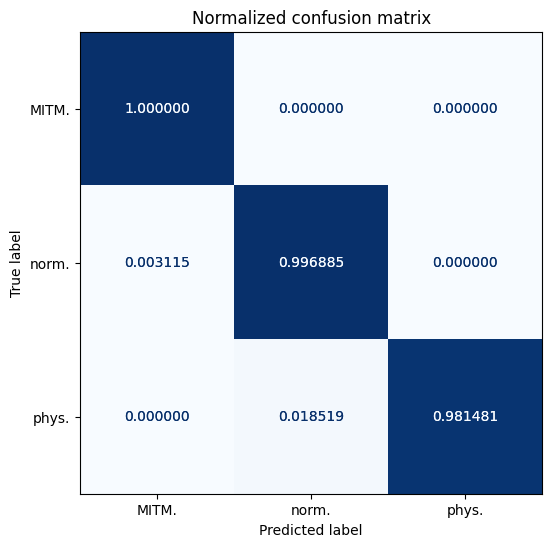

                precision    recall  f1-score   support

          MITM       0.99      1.00      1.00       109
        normal       1.00      1.00      1.00       321
physical fault       1.00      0.98      0.99        54

      accuracy                           1.00       484
     macro avg       1.00      0.99      0.99       484
  weighted avg       1.00      1.00      1.00       484


Metrics for class MITM:
True negative rate: 0.9973
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0027

Metrics for class normal:
True negative rate: 0.9939
True positive rate: 0.9969
False negative rate: 0.0031
False positive rate: 0.0061

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 0.9815
False negative rate: 0.0185
False positive rate: 0.0000


df_attack_2
taille 2104


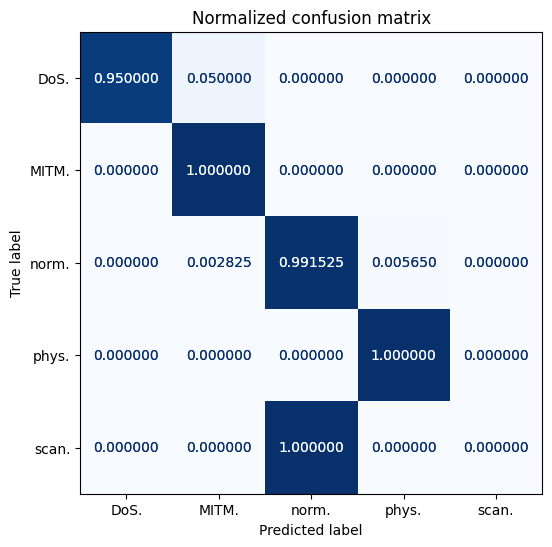

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

                precision    recall  f1-score   support

           DoS       1.00      0.95      0.97        20
          MITM       0.89      1.00      0.94        16
        normal       1.00      0.99      0.99       354
physical fault       0.94      1.00      0.97        30
          scan       0.00      0.00      0.00         1

      accuracy                           0.99       421
     macro avg       0.76      0.79      0.78       421
  weighted avg       0.99      0.99      0.99       421


Metrics for class DoS:
True negative rate: 1.0000
True positive rate: 0.9500
False negative rate: 0.0500
False positive rate: 0.0000

Metrics for class MITM:
True negative rate: 0.9951
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0049

Metrics for class normal:
True negative rate: 0.9851
True positive rate: 0.9915
False negative rate: 0.0085
False positive rate: 0.0149

Metrics for class physical fault:
True negative rate: 0.9949
True positive rate: 1.000

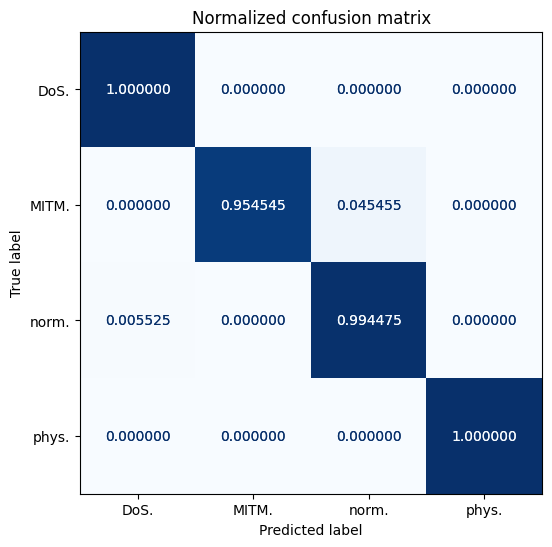

                precision    recall  f1-score   support

           DoS       0.92      1.00      0.96        12
          MITM       1.00      0.95      0.98        22
        normal       0.99      0.99      0.99       181
physical fault       1.00      1.00      1.00        36

      accuracy                           0.99       251
     macro avg       0.98      0.99      0.98       251
  weighted avg       0.99      0.99      0.99       251


Metrics for class DoS:
True negative rate: 0.9958
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0042

Metrics for class MITM:
True negative rate: 1.0000
True positive rate: 0.9545
False negative rate: 0.0455
False positive rate: 0.0000

Metrics for class normal:
True negative rate: 0.9857
True positive rate: 0.9945
False negative rate: 0.0055
False positive rate: 0.0143

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.000

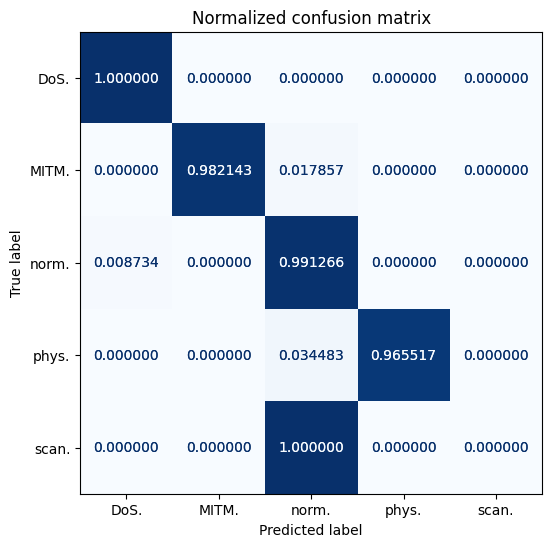

                precision    recall  f1-score   support

           DoS       0.94      1.00      0.97        29
          MITM       1.00      0.98      0.99        56
        normal       0.99      0.99      0.99       229
physical fault       1.00      0.97      0.98        29
          scan       0.00      0.00      0.00         1

      accuracy                           0.99       344
     macro avg       0.78      0.79      0.79       344
  weighted avg       0.98      0.99      0.98       344


Metrics for class DoS:
True negative rate: 0.9937
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0063

Metrics for class MITM:
True negative rate: 1.0000
True positive rate: 0.9821
False negative rate: 0.0179
False positive rate: 0.0000

Metrics for class normal:
True negative rate: 0.9739
True positive rate: 0.9913
False negative rate: 0.0087
False positive rate: 0.0261

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 0.965

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [18]:
dataframes = [df_attack_1, df_attack_2, df_attack_3, df_attack_4]
dataframes_name = ['df_attack_1', 'df_attack_2', 'df_attack_3', 'df_attack_4']

i=0
for df in dataframes:
    print("\n\n\033[1;33m" + dataframes_name[i] + "\033[0m")
    KNN_attack_detection(df, dataframes_name[i] + "_conf_mat", "KNN")
    i+=1

taille 7495


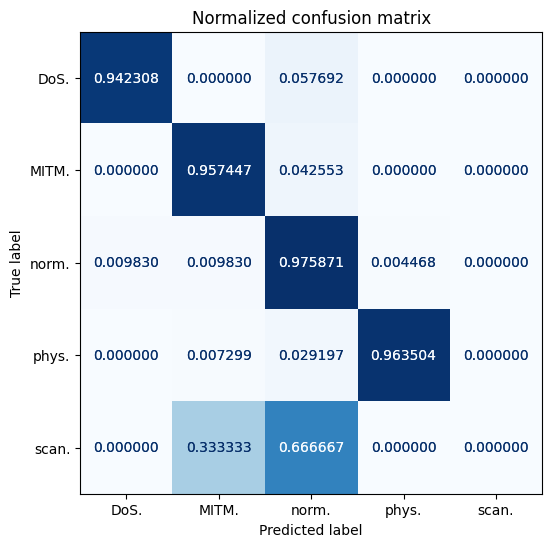

                precision    recall  f1-score   support

           DoS       0.82      0.94      0.87        52
          MITM       0.93      0.96      0.94       188
        normal       0.98      0.98      0.98      1119
physical fault       0.96      0.96      0.96       137
          scan       0.00      0.00      0.00         3

      accuracy                           0.97      1499
     macro avg       0.74      0.77      0.75      1499
  weighted avg       0.97      0.97      0.97      1499


Metrics for class DoS:
True negative rate: 0.9924
True positive rate: 0.9423
False negative rate: 0.0577
False positive rate: 0.0076

Metrics for class MITM:
True negative rate: 0.9901
True positive rate: 0.9574
False negative rate: 0.0426
False positive rate: 0.0099

Metrics for class normal:
True negative rate: 0.9553
True positive rate: 0.9759
False negative rate: 0.0241
False positive rate: 0.0447

Metrics for class physical fault:
True negative rate: 0.9963
True positive rate: 0.963

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [19]:
KNN_attack_detection(pd.concat([df_attack_1,df_attack_2,df_attack_3,df_attack_4]), "all_attacks_conf_mat", "KNN")

taille 10923


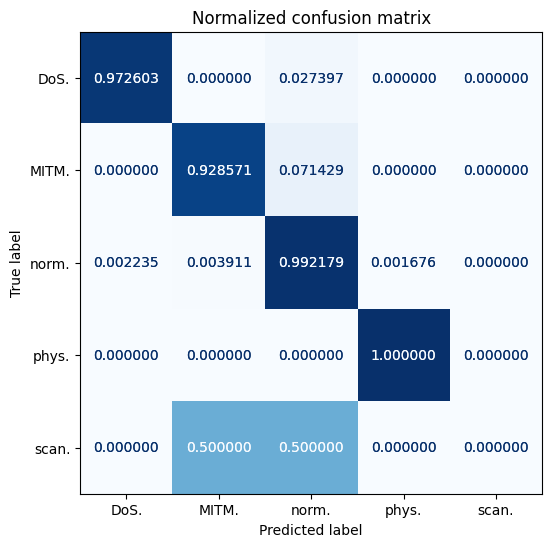

                precision    recall  f1-score   support

           DoS       0.95      0.97      0.96        73
          MITM       0.96      0.93      0.94       196
        normal       0.99      0.99      0.99      1790
physical fault       0.98      1.00      0.99       124
          scan       0.00      0.00      0.00         2

      accuracy                           0.99      2185
     macro avg       0.77      0.78      0.78      2185
  weighted avg       0.98      0.99      0.98      2185


Metrics for class DoS:
True negative rate: 0.9981
True positive rate: 0.9726
False negative rate: 0.0274
False positive rate: 0.0019

Metrics for class MITM:
True negative rate: 0.9960
True positive rate: 0.9286
False negative rate: 0.0714
False positive rate: 0.0040

Metrics for class normal:
True negative rate: 0.9570
True positive rate: 0.9922
False negative rate: 0.0078
False positive rate: 0.0430

Metrics for class physical fault:
True negative rate: 0.9985
True positive rate: 1.000

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [20]:
KNN_attack_detection(pd.concat([df_normal,df_attack_1,df_attack_2,df_attack_3,df_attack_4]), "all_attack_&_normal_conf_mat", "KNN")

### 3 - Random Forest



df_attack_1


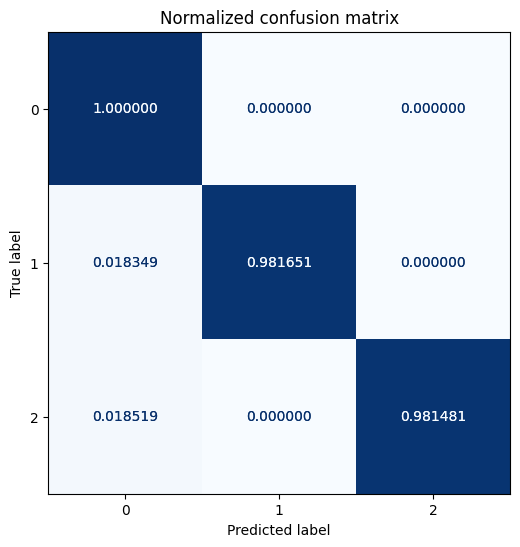

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       321
           1       1.00      0.98      0.99       109
           2       1.00      0.98      0.99        54

    accuracy                           0.99       484
   macro avg       1.00      0.99      0.99       484
weighted avg       0.99      0.99      0.99       484


Metrics for class 0:
True negative rate: 0.9816
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0184

Metrics for class 1:
True negative rate: 1.0000
True positive rate: 0.9817
False negative rate: 0.0183
False positive rate: 0.0000

Metrics for class 2:
True negative rate: 1.0000
True positive rate: 0.9815
False negative rate: 0.0185
False positive rate: 0.0000


df_attack_2


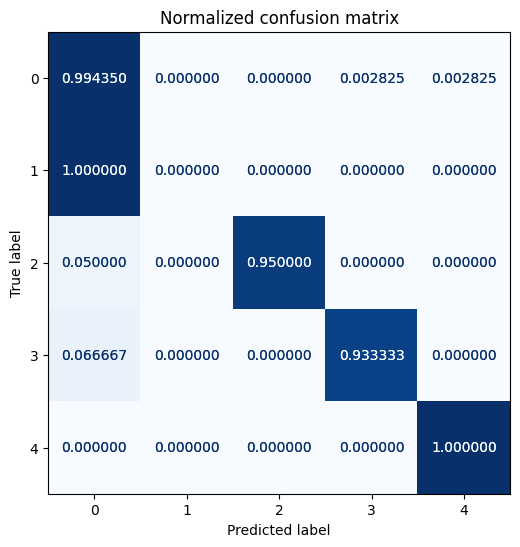

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       354
           1       0.00      0.00      0.00         1
           2       1.00      0.95      0.97        20
           3       0.97      0.93      0.95        30
           4       0.94      1.00      0.97        16

    accuracy                           0.99       421
   macro avg       0.78      0.78      0.78       421
weighted avg       0.98      0.99      0.98       421


Metrics for class 0:
True negative rate: 0.9403
True positive rate: 0.9944
False negative rate: 0.0056
False positive rate: 0.0597

Metrics for class 1:
True negative rate: 1.0000
True positive rate: 0.0000
False negative rate: 1.0000
False positive rate: 0.0000

Metrics for class 2:
True negative rate: 1.0000
True positive rate: 0.9500
False negative rate: 0.0500
False positive rate: 0.0000

Metrics for class 3:
True negative rate: 0.9974
True positive rate: 0.9333
False negative rate: 0.0667
False posit

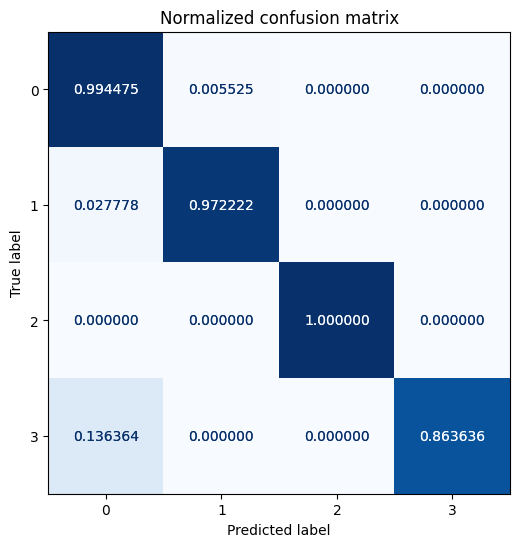

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       181
           1       0.97      0.97      0.97        36
           2       1.00      1.00      1.00        12
           3       1.00      0.86      0.93        22

    accuracy                           0.98       251
   macro avg       0.99      0.96      0.97       251
weighted avg       0.98      0.98      0.98       251


Metrics for class 0:
True negative rate: 0.9429
True positive rate: 0.9945
False negative rate: 0.0055
False positive rate: 0.0571

Metrics for class 1:
True negative rate: 0.9953
True positive rate: 0.9722
False negative rate: 0.0278
False positive rate: 0.0047

Metrics for class 2:
True negative rate: 1.0000
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0000

Metrics for class 3:
True negative rate: 1.0000
True positive rate: 0.8636
False negative rate: 0.1364
False positive rate: 0.0000


df_attack_4


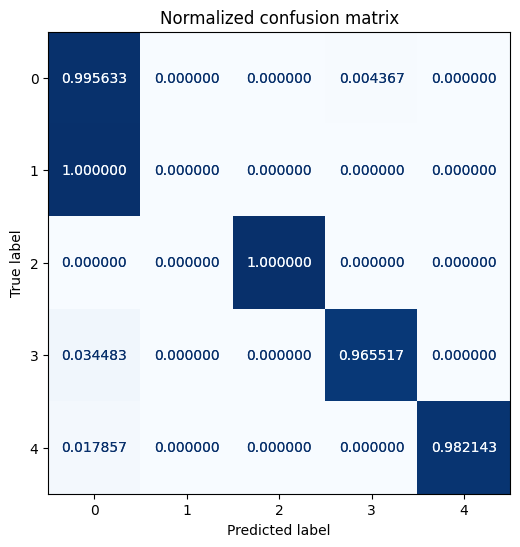

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       229
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00        29
           3       0.97      0.97      0.97        29
           4       1.00      0.98      0.99        56

    accuracy                           0.99       344
   macro avg       0.79      0.79      0.79       344
weighted avg       0.99      0.99      0.99       344


Metrics for class 0:
True negative rate: 0.9739
True positive rate: 0.9956
False negative rate: 0.0044
False positive rate: 0.0261

Metrics for class 1:
True negative rate: 1.0000
True positive rate: 0.0000
False negative rate: 1.0000
False positive rate: 0.0000

Metrics for class 2:
True negative rate: 1.0000
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0000

Metrics for class 3:
True negative rate: 0.9968
True positive rate: 0.9655
False negative rate: 0.0345
False posit

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [21]:
dataframes = [df_attack_1, df_attack_2, df_attack_3, df_attack_4]
dataframes_name = ['df_attack_1', 'df_attack_2', 'df_attack_3', 'df_attack_4']

i=0
for df in dataframes:
    print("\n\n\033[1;33m" + dataframes_name[i] + "\033[0m")
    randomForest_attack_detector(df, dataframes_name[i] + "_conf_mat", "Random_forest")
    i+=1

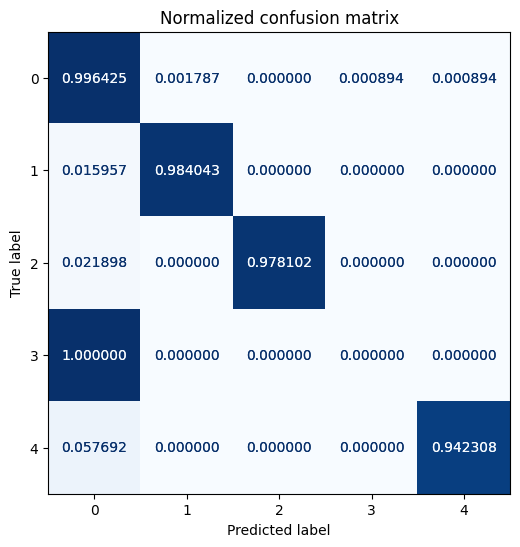

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1119
           1       0.99      0.98      0.99       188
           2       1.00      0.98      0.99       137
           3       0.00      0.00      0.00         3
           4       0.98      0.94      0.96        52

    accuracy                           0.99      1499
   macro avg       0.79      0.78      0.79      1499
weighted avg       0.99      0.99      0.99      1499


Metrics for class 0:
True negative rate: 0.9684
True positive rate: 0.9964
False negative rate: 0.0036
False positive rate: 0.0316

Metrics for class 1:
True negative rate: 0.9985
True positive rate: 0.9840
False negative rate: 0.0160
False positive rate: 0.0015

Metrics for class 2:
True negative rate: 1.0000
True positive rate: 0.9781
False negative rate: 0.0219
False positive rate: 0.0000

Metrics for class 3:
True negative rate: 0.9993
True positive rate: 0.0000
False negative rate: 1.0000
False posit

In [22]:
randomForest_attack_detector(pd.concat([df_attack_1,df_attack_2,df_attack_3,df_attack_4]), "all_attack_conf_mat", "Random_forest")

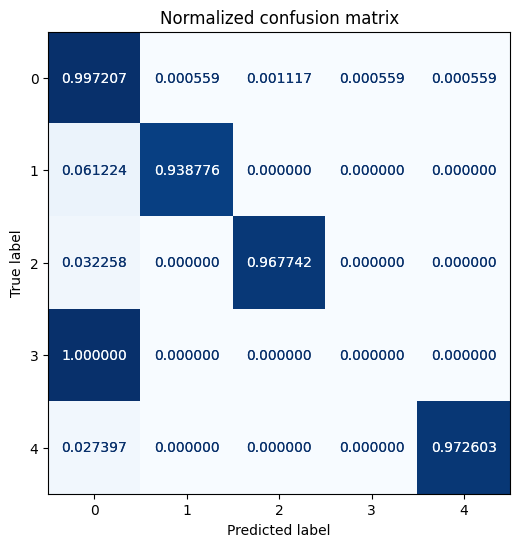

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1790
           1       0.99      0.94      0.97       196
           2       0.98      0.97      0.98       124
           3       0.00      0.00      0.00         2
           4       0.99      0.97      0.98        73

    accuracy                           0.99      2185
   macro avg       0.79      0.78      0.78      2185
weighted avg       0.99      0.99      0.99      2185


Metrics for class 0:
True negative rate: 0.9494
True positive rate: 0.9972
False negative rate: 0.0028
False positive rate: 0.0506

Metrics for class 1:
True negative rate: 0.9995
True positive rate: 0.9388
False negative rate: 0.0612
False positive rate: 0.0005

Metrics for class 2:
True negative rate: 0.9990
True positive rate: 0.9677
False negative rate: 0.0323
False positive rate: 0.0010

Metrics for class 3:
True negative rate: 0.9995
True positive rate: 0.0000
False negative rate: 1.0000
False posit

In [23]:
randomForest_attack_detector(pd.concat([df_normal,df_attack_1,df_attack_2,df_attack_3,df_attack_4]), "all_attack_&_normal_conf_mat", "Random_forest")

In [24]:
np.round([5.8,7,2.2])

array([6., 7., 2.])

### 3 - MLP



df_attack_1
taille 2420


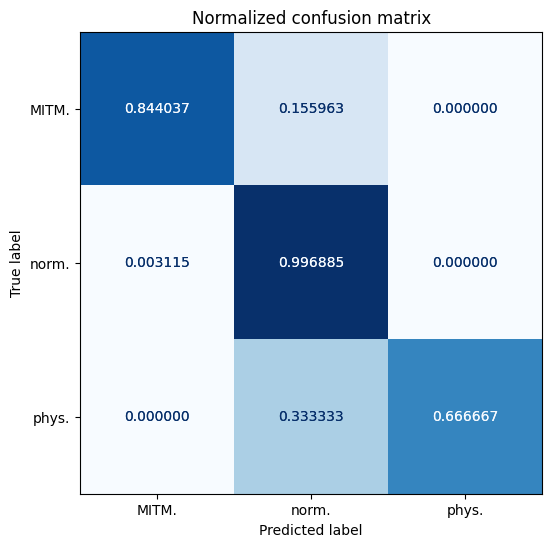

                precision    recall  f1-score   support

          MITM       0.99      0.84      0.91       109
        normal       0.90      1.00      0.95       321
physical fault       1.00      0.67      0.80        54

      accuracy                           0.93       484
     macro avg       0.96      0.84      0.89       484
  weighted avg       0.93      0.93      0.92       484


Metrics for class MITM:
True negative rate: 0.9973
True positive rate: 0.8440
False negative rate: 0.1560
False positive rate: 0.0027

Metrics for class normal:
True negative rate: 0.7853
True positive rate: 0.9969
False negative rate: 0.0031
False positive rate: 0.2147

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 0.6667
False negative rate: 0.3333
False positive rate: 0.0000


df_attack_2
taille 2104


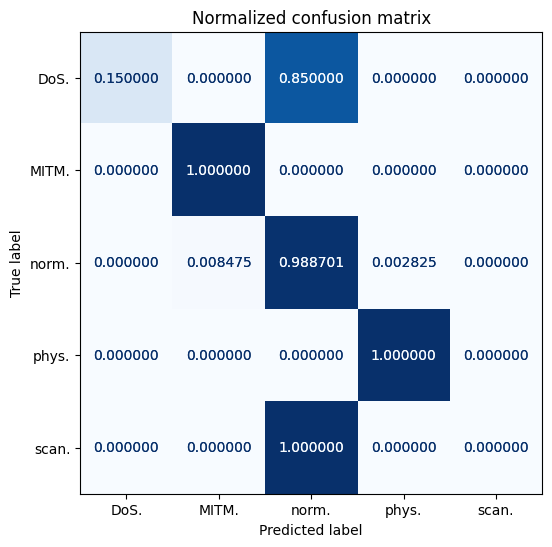

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

                precision    recall  f1-score   support

           DoS       1.00      0.15      0.26        20
          MITM       0.84      1.00      0.91        16
        normal       0.95      0.99      0.97       354
physical fault       0.97      1.00      0.98        30
          scan       0.00      0.00      0.00         1

      accuracy                           0.95       421
     macro avg       0.75      0.63      0.63       421
  weighted avg       0.95      0.95      0.93       421


Metrics for class DoS:
True negative rate: 1.0000
True positive rate: 0.1500
False negative rate: 0.8500
False positive rate: 0.0000

Metrics for class MITM:
True negative rate: 0.9926
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0074

Metrics for class normal:
True negative rate: 0.7313
True positive rate: 0.9887
False negative rate: 0.0113
False positive rate: 0.2687

Metrics for class physical fault:
True negative rate: 0.9974
True positive rate: 1.000

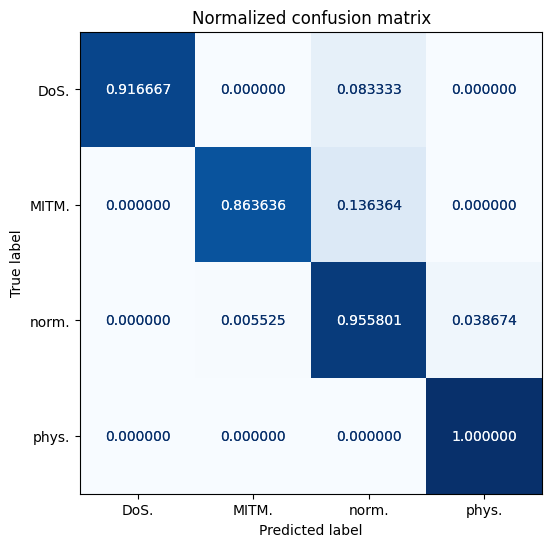

                precision    recall  f1-score   support

           DoS       1.00      0.92      0.96        12
          MITM       0.95      0.86      0.90        22
        normal       0.98      0.96      0.97       181
physical fault       0.84      1.00      0.91        36

      accuracy                           0.95       251
     macro avg       0.94      0.93      0.93       251
  weighted avg       0.96      0.95      0.95       251


Metrics for class DoS:
True negative rate: 1.0000
True positive rate: 0.9167
False negative rate: 0.0833
False positive rate: 0.0000

Metrics for class MITM:
True negative rate: 0.9956
True positive rate: 0.8636
False negative rate: 0.1364
False positive rate: 0.0044

Metrics for class normal:
True negative rate: 0.9429
True positive rate: 0.9558
False negative rate: 0.0442
False positive rate: 0.0571

Metrics for class physical fault:
True negative rate: 0.9674
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.032

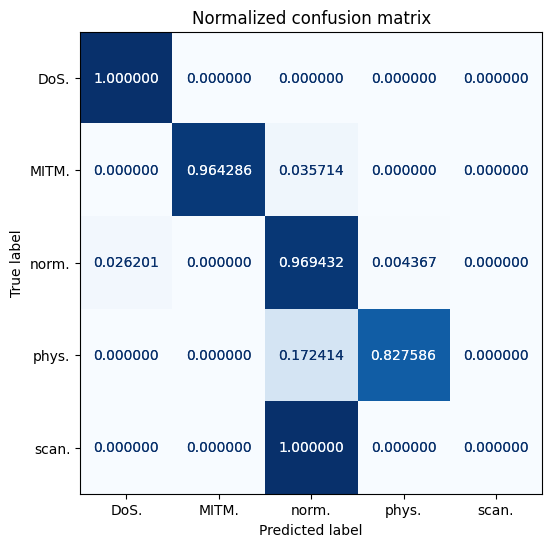

                precision    recall  f1-score   support

           DoS       0.83      1.00      0.91        29
          MITM       1.00      0.96      0.98        56
        normal       0.97      0.97      0.97       229
physical fault       0.96      0.83      0.89        29
          scan       0.00      0.00      0.00         1

      accuracy                           0.96       344
     macro avg       0.75      0.75      0.75       344
  weighted avg       0.96      0.96      0.96       344


Metrics for class DoS:
True negative rate: 0.9810
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0190

Metrics for class MITM:
True negative rate: 1.0000
True positive rate: 0.9643
False negative rate: 0.0357
False positive rate: 0.0000

Metrics for class normal:
True negative rate: 0.9304
True positive rate: 0.9694
False negative rate: 0.0306
False positive rate: 0.0696

Metrics for class physical fault:
True negative rate: 0.9968
True positive rate: 0.827

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [25]:
dataframes = [df_attack_1, df_attack_2, df_attack_3, df_attack_4]
dataframes_name = ['df_attack_1', 'df_attack_2', 'df_attack_3', 'df_attack_4']

i=0
for df in dataframes:
    print("\n\n\033[1;33m" + dataframes_name[i] + "\033[0m")
    MLP_attack_detector(df, dataframes_name[i] + "_conf_mat", "MLP")
    i+=1

### 4 - SVM



df_attack_1
taille 2420


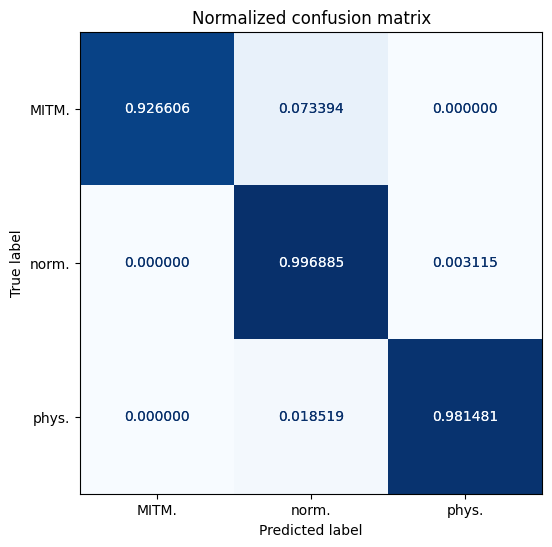

                precision    recall  f1-score   support

          MITM       1.00      0.93      0.96       109
        normal       0.97      1.00      0.98       321
physical fault       0.98      0.98      0.98        54

      accuracy                           0.98       484
     macro avg       0.98      0.97      0.98       484
  weighted avg       0.98      0.98      0.98       484


Metrics for class MITM:
True negative rate: 1.0000
True positive rate: 0.9266
False negative rate: 0.0734
False positive rate: 0.0000

Metrics for class normal:
True negative rate: 0.9448
True positive rate: 0.9969
False negative rate: 0.0031
False positive rate: 0.0552

Metrics for class physical fault:
True negative rate: 0.9977
True positive rate: 0.9815
False negative rate: 0.0185
False positive rate: 0.0023


df_attack_2
taille 2104


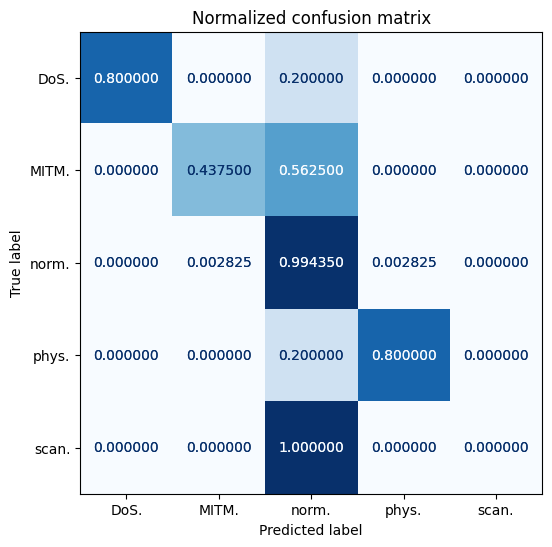

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

                precision    recall  f1-score   support

           DoS       1.00      0.80      0.89        20
          MITM       0.88      0.44      0.58        16
        normal       0.95      0.99      0.97       354
physical fault       0.96      0.80      0.87        30
          scan       0.00      0.00      0.00         1

      accuracy                           0.95       421
     macro avg       0.76      0.61      0.66       421
  weighted avg       0.94      0.95      0.94       421


Metrics for class DoS:
True negative rate: 1.0000
True positive rate: 0.8000
False negative rate: 0.2000
False positive rate: 0.0000

Metrics for class MITM:
True negative rate: 0.9975
True positive rate: 0.4375
False negative rate: 0.5625
False positive rate: 0.0025

Metrics for class normal:
True negative rate: 0.7015
True positive rate: 0.9944
False negative rate: 0.0056
False positive rate: 0.2985

Metrics for class physical fault:
True negative rate: 0.9974
True positive rate: 0.800

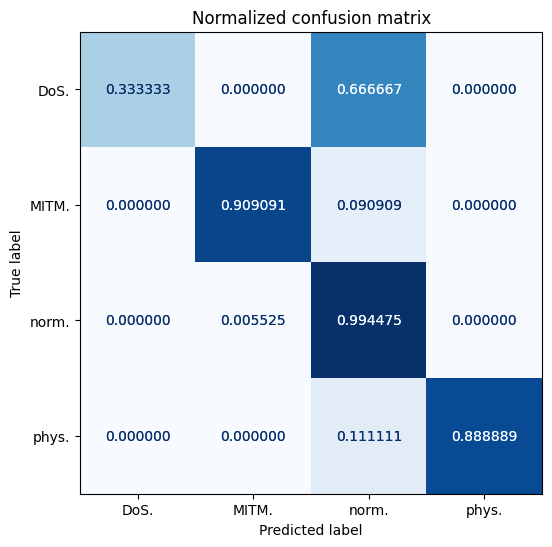

                precision    recall  f1-score   support

           DoS       1.00      0.33      0.50        12
          MITM       0.95      0.91      0.93        22
        normal       0.93      0.99      0.96       181
physical fault       1.00      0.89      0.94        36

      accuracy                           0.94       251
     macro avg       0.97      0.78      0.83       251
  weighted avg       0.94      0.94      0.93       251


Metrics for class DoS:
True negative rate: 1.0000
True positive rate: 0.3333
False negative rate: 0.6667
False positive rate: 0.0000

Metrics for class MITM:
True negative rate: 0.9956
True positive rate: 0.9091
False negative rate: 0.0909
False positive rate: 0.0044

Metrics for class normal:
True negative rate: 0.8000
True positive rate: 0.9945
False negative rate: 0.0055
False positive rate: 0.2000

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 0.8889
False negative rate: 0.1111
False positive rate: 0.000

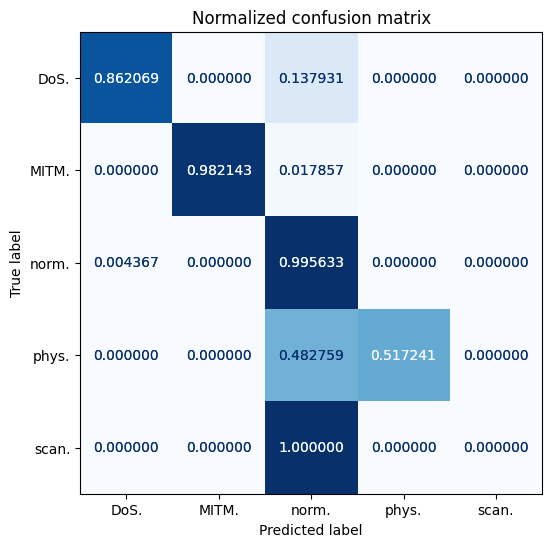

                precision    recall  f1-score   support

           DoS       0.96      0.86      0.91        29
          MITM       1.00      0.98      0.99        56
        normal       0.92      1.00      0.96       229
physical fault       1.00      0.52      0.68        29
          scan       0.00      0.00      0.00         1

      accuracy                           0.94       344
     macro avg       0.78      0.67      0.71       344
  weighted avg       0.94      0.94      0.93       344


Metrics for class DoS:
True negative rate: 0.9968
True positive rate: 0.8621
False negative rate: 0.1379
False positive rate: 0.0032

Metrics for class MITM:
True negative rate: 1.0000
True positive rate: 0.9821
False negative rate: 0.0179
False positive rate: 0.0000

Metrics for class normal:
True negative rate: 0.8261
True positive rate: 0.9956
False negative rate: 0.0044
False positive rate: 0.1739

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 0.517

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [26]:
dataframes = [df_attack_1, df_attack_2, df_attack_3, df_attack_4]
dataframes_name = ['df_attack_1', 'df_attack_2', 'df_attack_3', 'df_attack_4']

i=0
for df in dataframes:
    print("\n\n\033[1;33m" + dataframes_name[i] + "\033[0m")
    SVM_attack_detector(df, dataframes_name[i] + "_conf_mat", "SVM")
    i+=1

### 5 - CART



df_attack_1
taille 2420


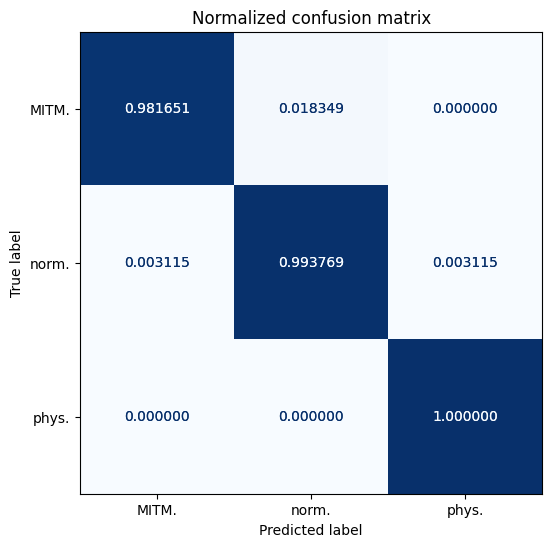

                precision    recall  f1-score   support

          MITM       0.99      0.98      0.99       109
        normal       0.99      0.99      0.99       321
physical fault       0.98      1.00      0.99        54

      accuracy                           0.99       484
     macro avg       0.99      0.99      0.99       484
  weighted avg       0.99      0.99      0.99       484


Metrics for class MITM:
True negative rate: 0.9973
True positive rate: 0.9817
False negative rate: 0.0183
False positive rate: 0.0027

Metrics for class normal:
True negative rate: 0.9877
True positive rate: 0.9938
False negative rate: 0.0062
False positive rate: 0.0123

Metrics for class physical fault:
True negative rate: 0.9977
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0023


df_attack_2
taille 2104


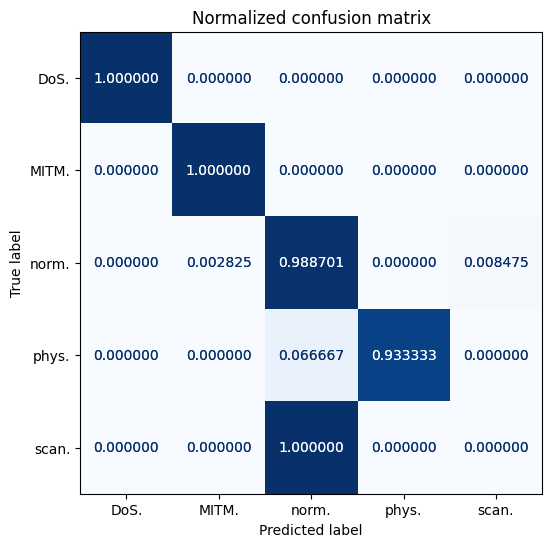

                precision    recall  f1-score   support

           DoS       1.00      1.00      1.00        20
          MITM       0.94      1.00      0.97        16
        normal       0.99      0.99      0.99       354
physical fault       1.00      0.93      0.97        30
          scan       0.00      0.00      0.00         1

      accuracy                           0.98       421
     macro avg       0.79      0.78      0.79       421
  weighted avg       0.99      0.98      0.99       421


Metrics for class DoS:
True negative rate: 1.0000
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0000

Metrics for class MITM:
True negative rate: 0.9975
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0025

Metrics for class normal:
True negative rate: 0.9552
True positive rate: 0.9887
False negative rate: 0.0113
False positive rate: 0.0448

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 0.933

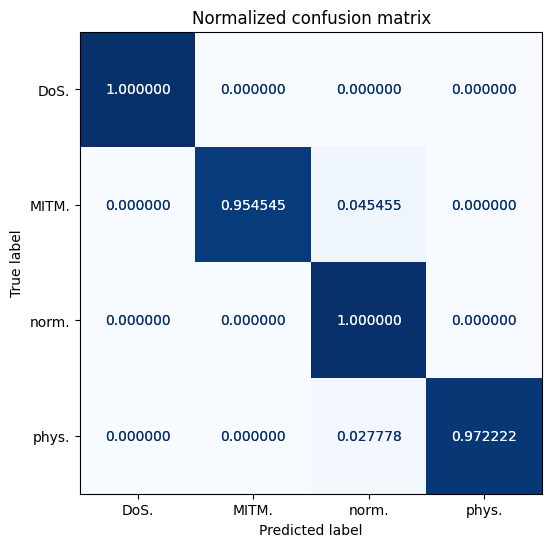

                precision    recall  f1-score   support

           DoS       1.00      1.00      1.00        12
          MITM       1.00      0.95      0.98        22
        normal       0.99      1.00      0.99       181
physical fault       1.00      0.97      0.99        36

      accuracy                           0.99       251
     macro avg       1.00      0.98      0.99       251
  weighted avg       0.99      0.99      0.99       251


Metrics for class DoS:
True negative rate: 1.0000
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0000

Metrics for class MITM:
True negative rate: 1.0000
True positive rate: 0.9545
False negative rate: 0.0455
False positive rate: 0.0000

Metrics for class normal:
True negative rate: 0.9714
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0286

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 0.9722
False negative rate: 0.0278
False positive rate: 0.000

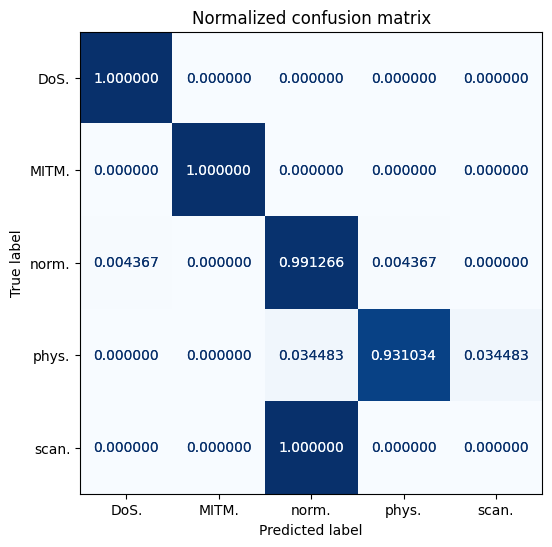

                precision    recall  f1-score   support

           DoS       0.97      1.00      0.98        29
          MITM       1.00      1.00      1.00        56
        normal       0.99      0.99      0.99       229
physical fault       0.96      0.93      0.95        29
          scan       0.00      0.00      0.00         1

      accuracy                           0.99       344
     macro avg       0.78      0.78      0.78       344
  weighted avg       0.99      0.99      0.99       344


Metrics for class DoS:
True negative rate: 0.9968
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0032

Metrics for class MITM:
True negative rate: 1.0000
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0000

Metrics for class normal:
True negative rate: 0.9826
True positive rate: 0.9913
False negative rate: 0.0087
False positive rate: 0.0174

Metrics for class physical fault:
True negative rate: 0.9968
True positive rate: 0.931

In [28]:
dataframes = [df_attack_1, df_attack_2, df_attack_3, df_attack_4]
dataframes_name = ['df_attack_1', 'df_attack_2', 'df_attack_3', 'df_attack_4']

i=0
for df in dataframes:
    print("\n\n\033[1;33m" + dataframes_name[i] + "\033[0m")
    CART_attack_detector(df, dataframes_name[i] + "_conf_mat", "CART")
    i+=1

### 6 - XGBoost



df_attack_1
taille 2420


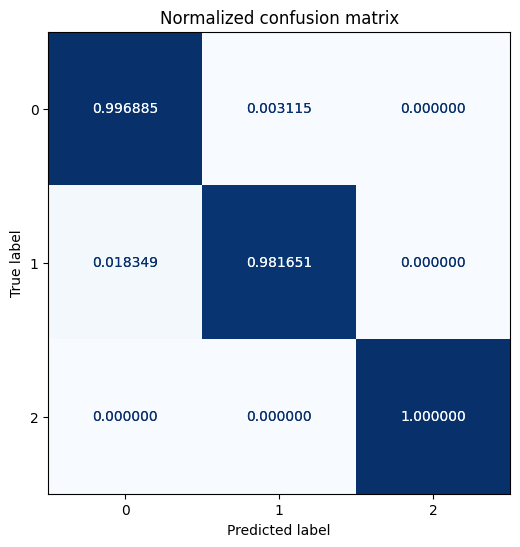

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       321
           1       0.99      0.98      0.99       109
           2       1.00      1.00      1.00        54

    accuracy                           0.99       484
   macro avg       0.99      0.99      0.99       484
weighted avg       0.99      0.99      0.99       484


Metrics for class 0:
True negative rate: 0.9877
True positive rate: 0.9969
False negative rate: 0.0031
False positive rate: 0.0123

Metrics for class 1:
True negative rate: 0.9973
True positive rate: 0.9817
False negative rate: 0.0183
False positive rate: 0.0027

Metrics for class 2:
True negative rate: 1.0000
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0000


df_attack_2
taille 2104


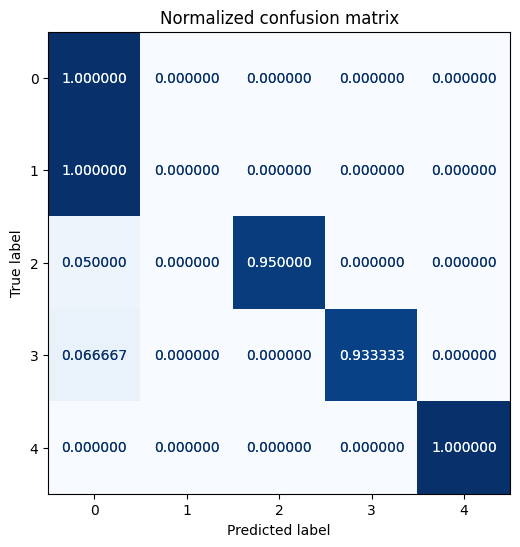

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       354
           1       0.00      0.00      0.00         1
           2       1.00      0.95      0.97        20
           3       1.00      0.93      0.97        30
           4       1.00      1.00      1.00        16

    accuracy                           0.99       421
   macro avg       0.80      0.78      0.79       421
weighted avg       0.99      0.99      0.99       421


Metrics for class 0:
True negative rate: 0.9403
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0597

Metrics for class 1:
True negative rate: 1.0000
True positive rate: 0.0000
False negative rate: 1.0000
False positive rate: 0.0000

Metrics for class 2:
True negative rate: 1.0000
True positive rate: 0.9500
False negative rate: 0.0500
False positive rate: 0.0000

Metrics for class 3:
True negative rate: 1.0000
True positive rate: 0.9333
False negative rate: 0.0667
False posit

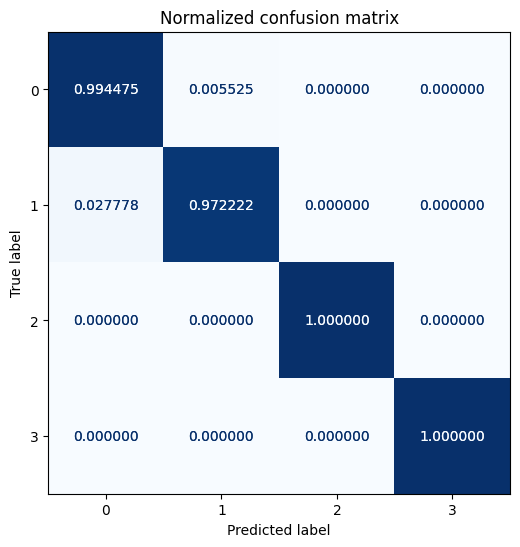

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       181
           1       0.97      0.97      0.97        36
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        22

    accuracy                           0.99       251
   macro avg       0.99      0.99      0.99       251
weighted avg       0.99      0.99      0.99       251


Metrics for class 0:
True negative rate: 0.9857
True positive rate: 0.9945
False negative rate: 0.0055
False positive rate: 0.0143

Metrics for class 1:
True negative rate: 0.9953
True positive rate: 0.9722
False negative rate: 0.0278
False positive rate: 0.0047

Metrics for class 2:
True negative rate: 1.0000
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0000

Metrics for class 3:
True negative rate: 1.0000
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0000


df_attack_4
taille 1717


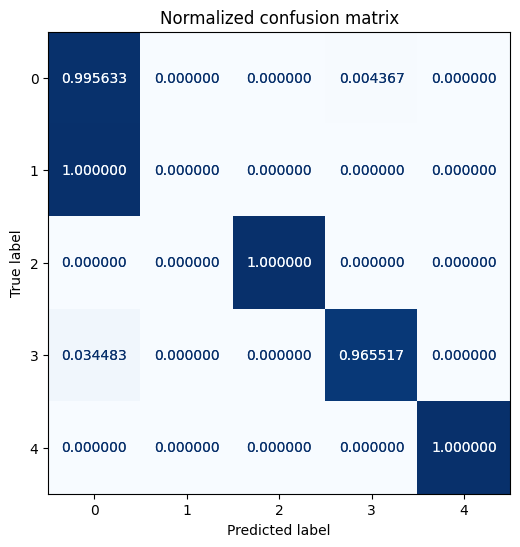

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       229
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00        29
           3       0.97      0.97      0.97        29
           4       1.00      1.00      1.00        56

    accuracy                           0.99       344
   macro avg       0.79      0.79      0.79       344
weighted avg       0.99      0.99      0.99       344


Metrics for class 0:
True negative rate: 0.9826
True positive rate: 0.9956
False negative rate: 0.0044
False positive rate: 0.0174

Metrics for class 1:
True negative rate: 1.0000
True positive rate: 0.0000
False negative rate: 1.0000
False positive rate: 0.0000

Metrics for class 2:
True negative rate: 1.0000
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0000

Metrics for class 3:
True negative rate: 0.9968
True positive rate: 0.9655
False negative rate: 0.0345
False posit

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [29]:
dataframes = [df_attack_1, df_attack_2, df_attack_3, df_attack_4]
dataframes_name = ['df_attack_1', 'df_attack_2', 'df_attack_3', 'df_attack_4']

i=0
for df in dataframes:
    print("\n\n\033[1;33m" + dataframes_name[i] + "\033[0m")
    XGB_attack_detector(df, dataframes_name[i] + "_conf_mat", "XGBoost")
    i+=1